In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# test data
address = '/home/dlopez/code/mtaha5/sign-language/raw_data/sign_mnist_test.csv'

# read CSV - DataFrame
df_test = pd.read_csv(address)

In [3]:
df_test.shape

(7172, 785)

In [4]:
# test data
address = '/home/dlopez/code/mtaha5/sign-language/raw_data/sign_mnist_train.csv'

# CSV into DataFrame
df_train = pd.read_csv(address)

In [5]:
df_train.shape

(27455, 785)

In [6]:
X_train=df_train.drop('label', axis=1)
y_train=df_train.label

In [7]:
X_test=df_test.drop('label', axis=1)
y_test=df_test.label

In [8]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

2023-11-28 20:12:11.432170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:12:11.776795: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:12:11.778923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 20:12:12.916800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
X_train.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [10]:
X_train.shape

(27455, 784)

In [11]:
X_train.values

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [12]:
#Re-shaping the images
X_train_images = X_train.values
X_train_images = np.array([np.reshape(i, (28, 28)) for i in X_train_images])
X_train_images = np.array([i.flatten() for i in X_train_images])

In [13]:
#label binarizer - target variable

from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
y_train_label = label_binrizer.fit_transform(y_train)

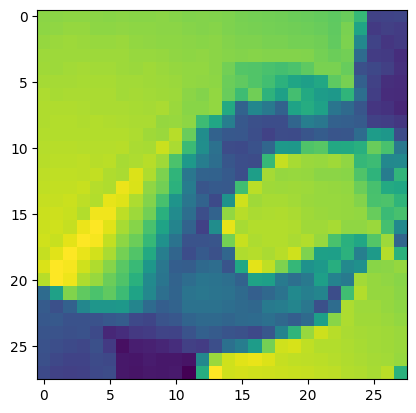

In [14]:
plt.imshow(X_train_images[3].reshape(28,28));

In [15]:
x_train = X_train_images / 255
#x_test = x_test / 255

In [16]:
x_train_t = np.stack([x_train.reshape(X_train.shape[0],28,28)]*3, axis=3).reshape(x_train.shape[0],28,28,3)
x_train_t.shape 

(27455, 28, 28, 3)

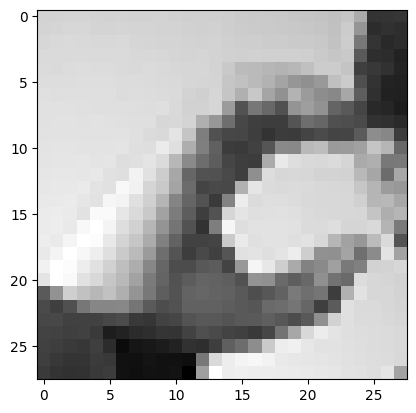

In [17]:
plt.imshow(x_train_t[3].reshape(28,28,3))

In [18]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img

x_train_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_train_t])/255
x_train_tt.shape

(27455, 48, 48, 3)

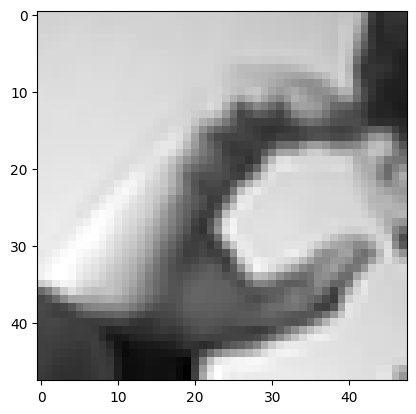

In [19]:
plt.imshow(x_train_tt[3].reshape(48,48,3))

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=x_train_tt[0].shape)    
    return model

In [21]:
#architecture of the model using
model = load_model()
model.summary()

2023-11-28 20:12:19.027781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 20:12:19.028089: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [22]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    return model

In [23]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(100, activation='relu')
    prediction_layer = layers.Dense(24, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

In [24]:
from tensorflow.keras import optimizers, models

def build_model():
    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [25]:
model_vgg16 = build_model()
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 14768412 (56.34 MB)
Trainable params: 53724 (209.86 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [26]:
#Split data into training and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_tt, y_train_label, test_size=0.3, random_state=42)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image data generator to training dataset and validation dataset
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [28]:
train_generator = train_datagen.flow( x_train, y_train, batch_size=64)

val_generator = val_datagen.flow( x_val, y_val, batch_size=64)


In [29]:
model_final = build_model()

es = EarlyStopping(patience = 4, restore_best_weights = True)

history = model_final.fit(train_generator,
                          steps_per_epoch=len(x_train) / 64,
                          validation_data=val_generator,
                          validation_steps=len(x_val) / 64,
                          epochs=50,
                          callbacks=[es],
                          verbose = 1)

Epoch 1/50
300/300 [==============================] - 73s 241ms/step - loss: 3.0170 - accuracy: 0.1578 - val_loss: 2.7282 - val_accuracy: 0.3006
Epoch 2/50
300/300 [==============================] - 77s 256ms/step - loss: 2.4966 - accuracy: 0.3628 - val_loss: 2.2939 - val_accuracy: 0.4198
Epoch 3/50
300/300 [==============================] - 77s 257ms/step - loss: 2.1347 - accuracy: 0.4431 - val_loss: 1.9876 - val_accuracy: 0.4721
Epoch 4/50
300/300 [==============================] - 78s 261ms/step - loss: 1.8820 - accuracy: 0.4941 - val_loss: 1.7865 - val_accuracy: 0.5177
Epoch 5/50
300/300 [==============================] - 77s 258ms/step - loss: 1.7119 - accuracy: 0.5299 - val_loss: 1.6513 - val_accuracy: 0.5424
Epoch 6/50
300/300 [==============================] - 78s 259ms/step - loss: 1.5907 - accuracy: 0.5519 - val_loss: 1.5373 - val_accuracy: 0.5645
Epoch 7/50
300/300 [==============================] - 77s 257ms/step - loss: 1.4885 - accuracy: 0.5800 - val_loss: 1.4578 - val_ac

In [30]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

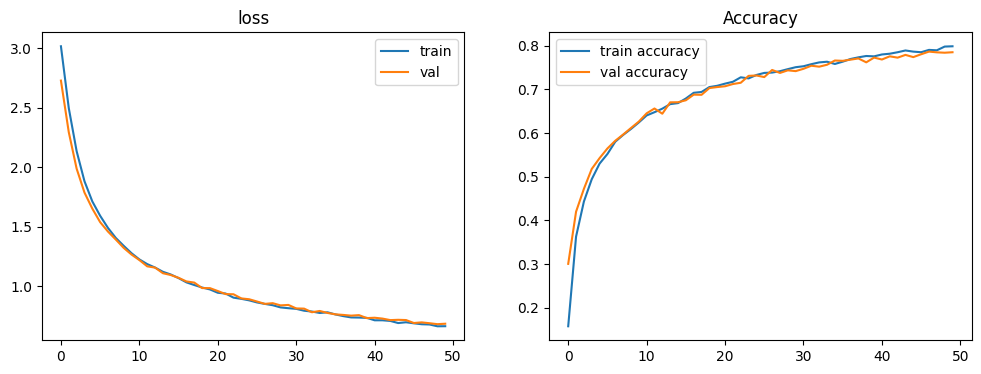

In [31]:
plot_history(history);

In [32]:
#Save the model 
model_final.save('model_50epoch.h5')

/home/dlopez/.pyenv/versions/3.8.12/envs/sign-language/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## classification report & confusion matrix on multiclass

In [ ]:
# letter={
#     0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
#     7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O',
#     14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V',
#     21: 'W', 22: 'X', 23: 'Y'
# }

# Evaluate the model

In [33]:
#Preprocessing the test dataset

#Re-shaping the images - Test dataset
X_test_images = X_test.values
X_test_images = np.array([np.reshape(i, (28, 28)) for i in X_test_images])
X_test_images = np.array([i.flatten() for i in X_test_images])

#label binarizer - target variable - Test dataset
y_test_label = label_binrizer.fit_transform(y_test)

#Normalize
x_test = X_test_images / 255
x_test_t = np.stack([x_test.reshape(x_test.shape[0],28,28)]*3, axis=3).reshape(x_test.shape[0],28,28,3)

# Resize the images 48*48 as required by VGG16
x_test_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_test_t])/255


In [34]:
#Evaluating the model

res_vgg = model_final.evaluate(x_test_tt, y_test_label)

test_accuracy_vgg = res_vgg[-1]

225/225 [==============================] - 17s 75ms/step - loss: 0.5264 - accuracy: 0.8313


# Import an image

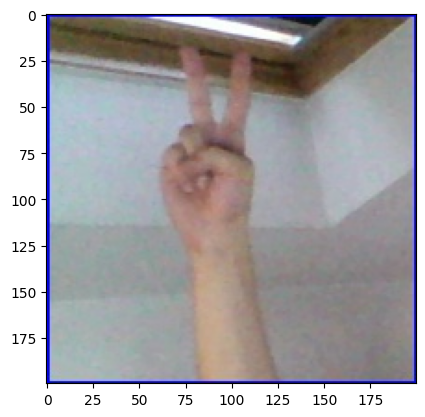

In [35]:
from PIL import Image

# Load the image
image_path = '/home/dlopez/code/mtaha5/sign-language/raw_data/asl_alphabet_train/V/V1161.jpg'  
img = Image.open(image_path)

# show the image
plt.imshow(img)
plt.axis('on') 
plt.show()

In [36]:
#Resize the image 48x48 , original is 200x200
img = img.resize((48, 48))

In [37]:
# Convert the image to an array using NumPy and normalize
img_array = np.array(img) / 255

In [38]:
img_array_expanded = np.expand_dims(img_array, axis=0)

In [39]:
img_array_expanded.shape

(1, 48, 48, 3)

## Prediction

In [40]:
letter={
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O',
    14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V',
    21: 'W', 22: 'X', 23: 'Y'
}

predict = model_final.predict(img_array_expanded)
predict

1/1 [==============================] - 1s 815ms/step


array([[9.7638742e-09, 7.7211762e-06, 9.9858903e-07, 2.1790307e-05,
        6.3786906e-08, 2.7043432e-08, 5.5561259e-02, 2.0880894e-01,
        6.5463342e-07, 2.3645125e-05, 1.3933966e-01, 2.9374300e-08,
        9.1124434e-08, 3.4545565e-08, 6.6106781e-02, 5.7830375e-06,
        5.2229702e-03, 2.4235195e-08, 5.2484930e-01, 6.6844859e-06,
        3.4608913e-06, 1.5687097e-07, 4.6136261e-06, 3.5326750e-05]],
      dtype=float32)

In [41]:
predict.shape

(1, 24)

In [45]:
predicted_class_index = np.argmax(predict)
letter_predicted=letter[predicted_class_index]
predicted_class_index, letter_predicted

(18, 'T')

### Plot all the label

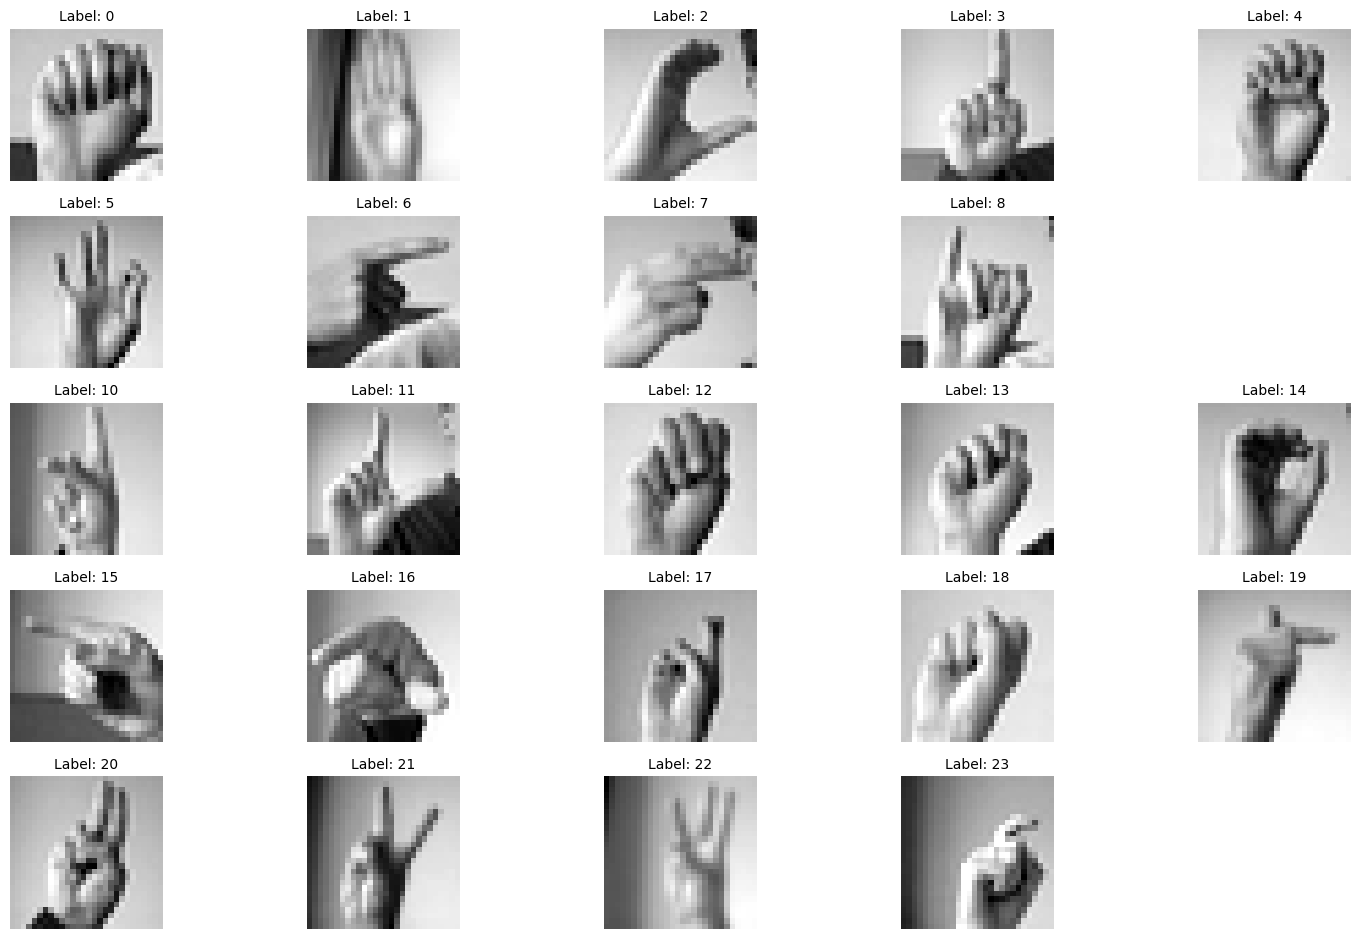

In [44]:
images = df_test.iloc[:, 1:].values  
labels = df_test['label'].values
num_images_per_label = 1 
num_columns = 5
num_rows = len(np.unique(labels)) 

plt.figure(figsize=(15, 45))

for label in range(len(np.unique(labels))):
    label_images = images[labels == label][:num_images_per_label]

    for i, img in enumerate(label_images, 1):
        plt.subplot(num_rows, num_columns, (label * num_images_per_label) + i)
        img = img.reshape(28, 28)  # Tamaño de la imagen: 28x28
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()